In [15]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import tqdm
import matplotlib.pyplot as pp
import numpy as np

In [16]:
INPUT_DIMS = 6
OUTPUT_DIMS = 6
NUM_EPOCHS = 50000
TRAJECTORY_LENGTH = 3
BATCH_SIZE = 10
START_NODE = 25

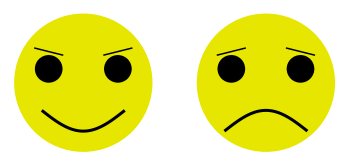

In [17]:
base_face = lambda: (pp.gca().add_patch(pp.Circle((0.5,0.5),0.5,fc=(.9,.9,0))),
                     pp.gca().add_patch(pp.Circle((0.25,0.6),0.1,fc=(0,0,0))),
                     pp.gca().add_patch(pp.Circle((0.75,0.6),0.1,fc=(0,0,0))))
patches = {
  'smile': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.3-np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'frown': lambda: pp.gca().add_patch(pp.Polygon(np.stack([np.linspace(0.2,0.8), 0.15+np.sin(np.linspace(0,3.14))*0.15]).T, closed=False, fill=False, lw=3)),
  'left_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.75,0.7], color=(0,0,0))),
  'right_eb_down': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.7,0.75], color=(0,0,0))),
  'left_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.15, 0.35], [0.7,0.75], color=(0,0,0))),
  'right_eb_up': lambda: pp.gca().add_line(pp.Line2D([0.65, 0.85], [0.75,0.7], color=(0,0,0))),
}
sorted_keys = sorted(patches.keys())

def draw_face(face):
  base_face()
  for i in face:
    patches[i]()
  pp.axis('scaled')
  pp.axis('off')

f, ax = pp.subplots(1,2)
pp.sca(ax[0])
draw_face(['smile', 'left_eb_down', 'right_eb_down'])
pp.sca(ax[1])
draw_face(['frown', 'left_eb_up', 'right_eb_up'])

In [18]:
def has_overlap(face):
  # Can't have two overlapping eyebrows!
  if 'left_eb_down' in face and 'left_eb_up' in face:
    return True
  if 'right_eb_down' in face and 'right_eb_up' in face:
    return True
  # Can't have two overlapping mouths!
  if 'smile' in face and 'frown' in face:
    return True
  return False

def face_reward(face):
  if has_overlap(face):
    return 0
  eyebrows = 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up'
  # Must have exactly two eyebrows
  if sum([i in face for i in eyebrows]) != 2:
    return 0
  # We want twice as many happy faces as sad faces so here we give a reward of 2 for smiles
  if 'smile' in face:
    return 2
  if 'frown' in face:
    return 1  # and a reward of 1 for frowns
  # If we reach this point, there's no mouth
  return 0

def face_to_tensor(face):
  return torch.tensor([i in face for i in sorted_keys]).float()


In [19]:
class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    # The input dimension is 6 for the 6 patches.
    self.mlp = nn.Sequential(nn.Linear(INPUT_DIMS, num_hid), nn.LeakyReLU(),
                             # We now output 12 numbers, 6 for P_F and 6 for P_B
                             nn.Linear(num_hid, OUTPUT_DIMS*2))
    # log Z is just a single number
    self.logZ = nn.Parameter(torch.ones(1))

  def forward(self, x):
    logits = self.mlp(x)
    # Slice the logits, and mask invalid actions (since we're predicting
    # log-values), we use -100 since exp(-100) is tiny, but we don't want -inf)
    print(logits)
    P_F = logits[..., :OUTPUT_DIMS] * (1 - x) + x * -100
    P_B = logits[..., OUTPUT_DIMS:] * x + (1 - x) * -100
    return P_F, P_B

In [20]:
transitions = {
    1: {0: 1, 1: 2, 2: 1, 3: 3, 4: 1},
    2: {0: 2, 1: 12, 2: 1, 3: 2, 4: 2},
    3: {0: 3, 1: 3, 2: 3, 3: 4, 4: 1},
    4: {0: 4, 1: 5, 2: 4, 3: 6, 4: 3},
    5: {0: 5, 1: 13, 2: 4, 3: 5, 4: 5},
    6: {0: 6, 1: 6, 2: 6, 3: 7, 4: 4},
    7: {0: 7, 1: 8, 2: 7, 3: 9, 4: 6},
    8: {0: 8, 1: 14, 2: 7, 3: 8, 4: 8},
    9: {0: 9, 1: 9, 2: 9, 3: 10, 4: 7},
    10: {0: 10, 1: 11, 2: 10, 3: 10, 4: 9},
    11: {0: 11, 1: 15, 2: 10, 3: 16, 4: 11},
    12: {0: 12, 1: 18, 2: 2, 3: 12, 4: 12},
    13: {0: 13, 1: 19, 2: 5, 3: 13, 4: 13},
    14: {0: 14, 1: 20, 2: 8, 3: 14, 4: 14},
    15: {0: 15, 1: 21, 2: 11, 3: 17, 4: 15},
    16: {0: 16, 1: 17, 2: 16, 3: 16, 4: 11},
    17: {0: 17, 1: 22, 2: 16, 3: 23, 4: 15},
    18: {0: 18, 1: 18, 2: 12, 3: 25, 4: 18},
    19: {0: 19, 1: 19, 2: 13, 3: 26, 4: 25},
    20: {0: 20, 1: 20, 2: 14, 3: 27, 4: 26},
    21: {0: 21, 1: 21, 2: 15, 3: 22, 4: 27},
    22: {0: 22, 1: 22, 2: 17, 3: 24, 4: 21},
    23: {0: 23, 1: 24, 2: 17, 3: 23, 4: 17},
    24: {0: 24, 1: 22, 2: 23, 3: 24, 4: 22},
    25: {0: 25, 1: 25, 2: 25, 3: 19, 4: 18},
    26: {0: 26, 1: 26, 2: 26, 3: 20, 4: 19},
    27: {0: 27, 1: 27, 2: 27, 3: 21, 4: 20}
}
def state_to_vec(state):
    result = [0]*27
    result[state-1] = 1
    return torch.tensor(result).float()

In [21]:
# Instantiate model and optimizer
model = TBModel(512)
opt = torch.optim.Adam(model.parameters(),  3e-4)

# Let's keep track of the losses and the faces we sample
tb_losses = []
tb_sampled_faces = []
tb_rewards = []
logZs = []

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode.
minibatch_loss = 0
minibatch_reward = 0

for episode in tqdm.tqdm(range(NUM_EPOCHS), ncols=40):
  # Each episode starts with an "empty state"
  state = []
  # Predict P_F, P_B
  P_F_s, P_B_s = model(face_to_tensor(state))
  total_P_F = 0
  total_P_B = 0
  for t in range(TRAJECTORY_LENGTH):
    # Here P_F is logits, so we want the Categorical to compute the softmax for us
    cat = Categorical(logits=P_F_s)
    action = cat.sample()
    # "Go" to the next state
    new_state = state + [sorted_keys[action]]
    # Accumulate the P_F sum
    total_P_F += cat.log_prob(action)

    if t == TRAJECTORY_LENGTH-1:
      # If we've built a complete face, we're done, so the reward is > 0
      # (unless the face is invalid)
      reward = torch.tensor(face_reward(new_state)).float()
    # We recompute P_F and P_B for new_state
    P_F_s, P_B_s = model(face_to_tensor(new_state))
    # Here we accumulate P_B, going backwards from `new_state`. We're also just
    # going to use opposite semantics for the backward policy. I.e., for P_F action
    # `i` just added the face part `i`, for P_B we'll assume action `i` removes
    # face part `i`, this way we can just keep the same indices.
    total_P_B += Categorical(logits=P_B_s).log_prob(action)

    # Continue iterating
    state = new_state

  # We're done with the trajectory, let's compute its loss. Since the reward can
  # sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
  loss = (model.logZ + total_P_F - torch.log(reward).clip(-20) - total_P_B).pow(2)
  minibatch_loss += loss
  minibatch_reward += reward


  # Add the face to the list, and if we are at an
  # update episode, take a gradient step.
  tb_sampled_faces.append(state)
  if episode % BATCH_SIZE == 0:
    tb_losses.append(minibatch_loss.item())
    tb_rewards.append(minibatch_reward.item())
    minibatch_loss.backward()
    opt.step()
    opt.zero_grad()
    minibatch_loss = 0
    minibatch_reward = 0
    logZs.append(model.logZ.item())


100%|█| 50000/50000 [00:45<00:00, 1110.1


Text(0, 0.5, 'rewards')

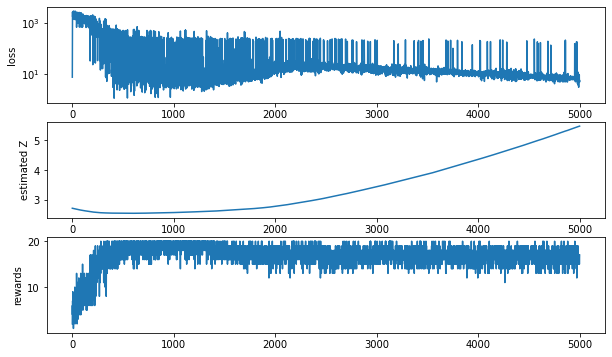

In [23]:
f, ax = pp.subplots(3, 1, figsize=(10,6))
pp.sca(ax[0])
pp.plot(tb_losses)
pp.yscale('log')
pp.ylabel('loss')
pp.sca(ax[1])
pp.plot(np.exp(logZs))
pp.ylabel('estimated Z')
pp.sca(ax[2])
pp.plot(tb_rewards)
pp.ylabel('rewards')